## KDS75

In [1]:
# Load modules
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import seaborn as sns

from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
from mpl_toolkits.basemap import Basemap # plot on map projections
import xarray as xr


netcdf_index loaded.


In [2]:
from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

In [3]:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 8787:127.0.0.1:8787 vdi-n26.nci.org.au -l pas561


Client Scheduler: tcp://127.0.0.1:37325 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


In [4]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)
#my xarray version is old, no cumsum. Should be version 0.9.2 or newer?

0.10.0


In [5]:
cc.build_index()

Files found but not yet indexed: 0
No new .nc files found.


True

In [6]:
configuration = 'mom01v5'
expts = cc.get_experiments(configuration)
display(expts)


['GFDL50',
 'KDS75',
 'KDS75_PI',
 'KDS75_UP',
 'KDS75_WOA13',
 'KDS75_newbathy_CORE',
 'KDS75_newbathy_JRA',
 'KDS75_newbathy_JRA_runoff',
 'KDS75_salt10days',
 'KDS75_saltfluxes',
 'KDS75_wind',
 'kds75_cp',
 'kds75_wp2']

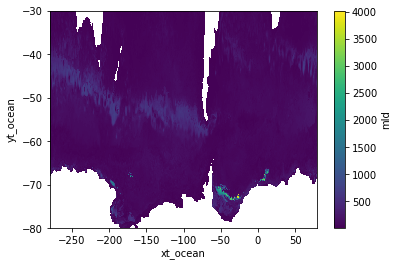

In [31]:
expt='kds75_cp'
mld= cc.get_nc_variable(expt,
                    'ocean_month.nc',
                    'mld',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
mean_mld = mld.sel(yt_ocean=slice(-80,-30)).sel(time='1975-09').mean('time')
#mean_mld = mld.mean('time')
mean_mld.plot.pcolormesh()

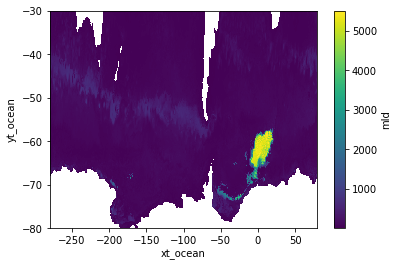

In [30]:
expt='kds75_wp2'
mld= cc.get_nc_variable(expt,
                    'ocean_month.nc',
                    'mld',
                    time_units='days since 1860-01-01',
                    use_bag=True,
                    )
#mean_mld = mld.sel(time=slice('1975-01','1975-12')).mean('time')
mean_mld = mld.sel(yt_ocean=slice(-80,-30)).sel(time='1975-09').mean('time')
#mean_mld = mld.mean('time')
mean_mld.plot.pcolormesh()

In [ ]:
pert_i=cc.get_nc_variable('kds75_wp2',
                    'ice_month.nc',
                    'CN',
                    time_units='days since 1973-04-01',
                    use_bag=True,
                    chunks={'time': 1}
                    )
septice = pert_i.sel(yt_ocean=slice(-80,-55)).sum('ct')

In [ ]:
septice.isel(time=18).plot.pcolormesh()

In [11]:
#if i fist ncrcat the CN data into an netcdf file, it works and is very fast
Ocean_File = os.path.join(NYFPertDir,'CN.cat.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN.shape
print pert_i.CN[:,:,:,:].sum('ct').shape

(87, 5, 2700, 3600)
(87, 2700, 3600)


In [7]:
#even more painful is calculating the overturning
Ocean_File = os.path.join(NYFPertDir,'output4*/ocean.nc')
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(pert.ty_trans_rho.shape)

pert_gmoc=pert.ty_trans_rho[:,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()
print(pert_gmoc.shape)

of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
a=np.save(of,pert_gmoc)



(29, 75, 2700, 3600)


MemoryError: 

In [ ]:
#instead I can opt for the slow, but successful version below:
print pert.ty_trans_rho.shape[0]

pert_gmoc=np.zeros((pert.ty_trans_rho.shape[0],pert.ty_trans_rho.shape[1],pert.ty_trans_rho.shape[2]))
print pert_gmoc.shape

for t in range(pert.ty_trans.shape[0]):
    print t
    pert_gmoc[t,:,:]=pert.ty_trans_rho[t,:,:,:].sum('grid_xt_ocean').cumsum('potrho').load()

print pert_gmoc.shape

of=os.path.join(NYFPertDir,'gmoc_adv_rho.npy')
a=np.save(of,pert_gmoc)


In [ ]:
expt='kds75_cp'
psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=5,
                          time_units = 'days since 1700-01-01')
psi = psi.sum('grid_xt_ocean')
psi_avg = psi.cumsum('potrho').mean('time') -  psi.sum('potrho').mean('time')
psi_avg.load()

Text(0.5,1,'Overturning in kds75_cp')

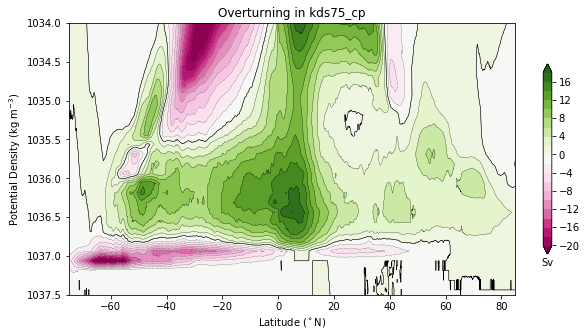

In [33]:
plt.figure(figsize=(10, 5)) 
clev=np.arange(-20,20,2)
plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()
    
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning in %s' % expt)

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=48), HTML(value='')))

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=29), HTML(value='')))

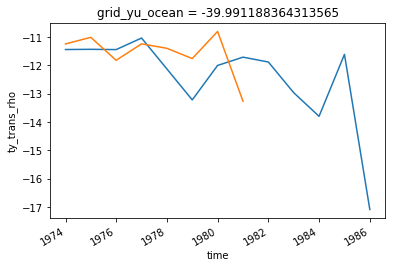

In [21]:
expts = ['kds75_cp','kds75_wp2']

for e in expts:
    psi = cc.get_nc_variable(e, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},
                          time_units = 'days since 1860-01-01')
    psi = psi.sum('grid_xt_ocean')
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    psi_aabw = psi_sum.sel(method='Nearest',grid_yu_ocean=-40).sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean()
    psi_aabw = psi_aabw.compute()
    psi_aabw.plot(label=e)